In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
sentiment = pd.read_csv("C:/Users/Dev Tandon/Downloads/fear_greed_index.csv")
trades = pd.read_csv("C:/Users/Dev Tandon/Downloads/historical_data.csv")


In [10]:
sentiment.shape
trades.shape


(211224, 16)

In [11]:
sentiment.columns
trades.columns


Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp'],
      dtype='object')

In [12]:
sentiment.isna().sum()
trades.isna().sum()


account             0
coin                0
execution_price     0
size_tokens         0
size_usd            0
side                0
timestamp_ist       0
start_position      0
direction           0
closed_pnl          0
transaction_hash    0
order_id            0
crossed             0
fee                 0
trade_id            0
timestamp           0
dtype: int64

In [13]:
sentiment.columns = sentiment.columns.str.strip().str.lower()
trades.columns = (
    trades.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)


In [15]:
trades['timestamp_ist'] = pd.to_datetime(
    trades['timestamp_ist'],
    dayfirst=True,
    errors='coerce'
)


In [16]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date
trades['timestamp_ist'] = pd.to_datetime(trades['timestamp_ist'])
trades['date'] = trades['timestamp_ist'].dt.date


In [17]:
daily_metrics = (
    trades.groupby(['date', 'account'])
    .agg(
        daily_pnl=('closed_pnl', 'sum'),
        trade_count=('trade_id', 'count'),
        avg_trade_size=('size_usd', 'mean'),
        total_volume=('size_usd', 'sum')
    )
    .reset_index()
)


In [18]:
trades['win'] = trades['closed_pnl'] > 0

win_rate = (
    trades.groupby(['date', 'account'])['win']
    .mean()
    .reset_index(name='win_rate')
)

daily_metrics = daily_metrics.merge(
    win_rate, on=['date', 'account'], how='left'
)


In [19]:
ls_ratio = (
    trades.groupby(['date', 'side'])
    .size()
    .unstack(fill_value=0)
)

ls_ratio['long_short_ratio'] = (
    ls_ratio.get('buy', 0) / (ls_ratio.get('sell', 1))
)

ls_ratio = ls_ratio[['long_short_ratio']].reset_index()


In [20]:
sentiment_daily = sentiment[['date', 'classification', 'value']]

final_df = daily_metrics.merge(
    sentiment_daily,
    on='date',
    how='left'
)


In [21]:
final_df.head()


,date,account,daily_pnl,trade_count,avg_trade_size,total_volume,win_rate,classification,value
0,2023-05-01,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000,3,159.000000,477.00,0.000000,Greed,63.0
1,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000,9,5556.203333,50005.83,0.000000,Extreme Greed,75.0
2,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-205.434737,11,10291.213636,113203.35,0.363636,Greed,72.0
3,2023-12-15,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-24.632034,2,5304.975000,10609.95,0.000000,Greed,70.0
4,2023-12-16,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000,3,5116.256667,15348.77,0.000000,Greed,67.0


In [22]:
final_df.groupby('classification')['daily_pnl'].describe()


,count,mean,std,min,25%,50%,75%,max
classification,,,,,,,,
Extreme Fear,160.0,4619.439053,29534.839183,-77308.420095,0.0,218.377399,3381.323773,229058.684298
Extreme Greed,526.0,5161.922644,27496.863832,-132271.000000,0.0,418.319862,2385.426442,449328.107544
Fear,630.0,5328.818161,31659.771538,-108604.496278,0.0,107.892532,1807.148049,533974.662903
Greed,648.0,3318.100730,30599.040173,-358963.139984,0.0,158.214922,1319.220865,375620.270243
Neutral,376.0,3438.618818,17447.863645,-113601.020138,0.0,167.551743,1321.966347,194499.072534


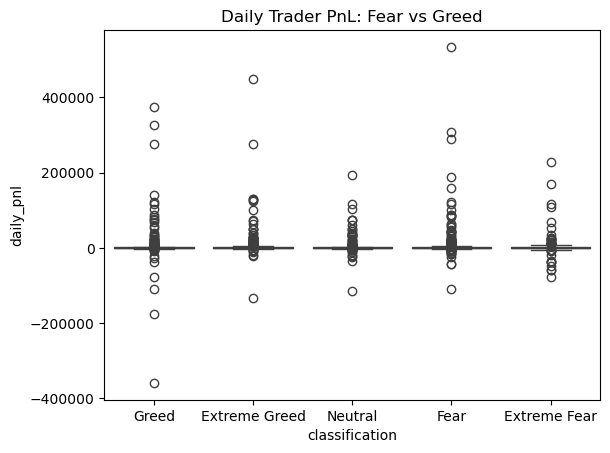

In [23]:
sns.boxplot(data=final_df, x='classification', y='daily_pnl')
plt.title("Daily Trader PnL: Fear vs Greed")
plt.show()


In [24]:
final_df.groupby('classification').agg({
    'trade_count': 'mean',
    'avg_trade_size': 'mean',
    'win_rate': 'mean'
})


,trade_count,avg_trade_size,win_rate
classification,,,
Extreme Fear,133.750000,6773.464125,0.329659
Extreme Greed,76.030418,5371.637182,0.386387
Fear,98.153968,8975.928546,0.364033
Greed,77.628086,6427.866594,0.343559
Neutral,100.228723,6963.694861,0.355414


In [25]:
final_df['activity_segment'] = np.where(
    final_df['trade_count'] > final_df['trade_count'].median(),
    'High Activity',
    'Low Activity'
)


In [26]:
consistency = (
    final_df.groupby('account')['win_rate']
    .mean()
    .reset_index(name='avg_win_rate')
)

final_df = final_df.merge(consistency, on='account')

final_df['consistency_segment'] = np.where(
    final_df['avg_win_rate'] > 0.55,
    'Consistent',
    'Inconsistent'
)


In [27]:
final_df.groupby(
    ['classification', 'activity_segment']
)['daily_pnl'].mean()


classification  activity_segment
Extreme Fear    High Activity        6799.753651
                Low Activity          457.020275
Extreme Greed   High Activity        8437.437459
                Low Activity         1627.473851
Fear            High Activity       10311.492505
                Low Activity          913.034911
Greed           High Activity        5486.377107
                Low Activity         1401.949513
Neutral         High Activity        5759.162182
                Low Activity         1118.075454
Name: daily_pnl, dtype: float64

In [28]:
final_df['profitable'] = final_df['daily_pnl'] > 0

from sklearn.ensemble import RandomForestClassifier

X = final_df[['trade_count', 'avg_trade_size']]
y = final_df['profitable']

model = RandomForestClassifier()
model.fit(X, y)


RandomForestClassifier()